In [ ]:
pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.2 MB/s eta 0:00:00


In [ ]:
import os

import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import librosa
import numpy as np
import pickle

from sklearn.utils import shuffle
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow_addons.metrics import F1Score


In [ ]:
from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Global vars
RANDOM_SEED = 1337
SAMPLE_RATE = 32000
SIGNAL_LENGTH = 5 # seconds
SPEC_SHAPE = (48, 128) # height x width
FMIN = 500
FMAX = 12500
# MAX_AUDIO_FILES = 10000
EPOCHS=50

***2. Data preparation***

In [ ]:
import os
import pandas as pd

audio_base_dir = '/content/gdrive/MyDrive/DsiM70/Dataset_TRAIN'

train_data = []
file_count = {}

for folder_name in os.listdir(audio_base_dir):
    sub_folder = os.path.join(audio_base_dir, folder_name)
    if os.path.isdir(sub_folder):
        file_count[folder_name] = 0
        for file_name in os.listdir(sub_folder):
            if file_name.endswith('.ogg'):
                train_data.append({'nome_file': file_name, 'label': folder_name})
                file_count[folder_name] += 1

TRAIN = pd.DataFrame(train_data)

print(f"Numero di campioni di training: {len(TRAIN)}")




Numero di campioni di training: 1700


In [ ]:
LABELS = sorted(TRAIN['label'].unique())

In [ ]:
print('NUMBER OF SPECIES IN TRAIN DATA:', len(LABELS))
print('NUMBER OF SAMPLES IN TRAIN DATA:', len(TRAIN))

NUMBER OF SPECIES IN TRAIN DATA: 25
NUMBER OF SAMPLES IN TRAIN DATA: 1700


In [ ]:
# saving labels
with open('LABELS.pkl','wb') as f:
    pickle.dump(LABELS,f)

from google.colab import files

file_path = 'LABELS.pkl'

files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

***extracting spectrograms***

In [ ]:
TRAIN = shuffle(TRAIN, random_state=RANDOM_SEED)


def get_spectrograms(filepath, primary_label, output_dir):

    sig, rate = librosa.load(filepath, sr=SAMPLE_RATE, offset=None, duration=15)

    sig_splits = []
    for i in range(0, len(sig), int(SIGNAL_LENGTH * SAMPLE_RATE)):
        split = sig[i:i + int(SIGNAL_LENGTH * SAMPLE_RATE)]

        if len(split) < int(SIGNAL_LENGTH * SAMPLE_RATE):
            break

        sig_splits.append(split)

    s_cnt = 0
    saved_samples = []
    for chunk in sig_splits:

        hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))
        mel_spec = librosa.feature.melspectrogram(y=chunk,
                                                  sr=SAMPLE_RATE,
                                                  n_fft=1024,
                                                  hop_length=hop_length,
                                                  n_mels=SPEC_SHAPE[0],
                                                  fmin=FMIN,
                                                  fmax=FMAX)

        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        mel_spec -= mel_spec.min()
        mel_spec /= mel_spec.max()

        save_dir = os.path.join(output_dir, primary_label)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, filepath.rsplit(os.sep, 1)[-1].rsplit('.', 1)[0] +
                                 '_' + str(s_cnt) + '.png')
        im = Image.fromarray(mel_spec * 255.0).convert("L")
        im.save(save_path)

        saved_samples.append(save_path)
        s_cnt += 1


    return saved_samples

print('FINAL NUMBER OF AUDIO FILES IN TRAINING DATA:', len(TRAIN))

FINAL NUMBER OF AUDIO FILES IN TRAINING DATA: 1700


In [ ]:
from tqdm import tqdm
from sklearn.utils import shuffle

input_dir = '/content/gdrive/MyDrive/DsiM/Dataset_TRAIN'
output_dir = '/content/gdrive/MyDrive/DsiM/Dataset_finale_Spettrogrammi_TRAIN'

samples = []
with tqdm(total=len(TRAIN)) as pbar:
    for idx, row in TRAIN.iterrows():
        pbar.update(1)

        audio_file_path = os.path.join(input_dir, row['label'], row['nome_file'])

        samples += get_spectrograms(audio_file_path, row['label'], output_dir)

TRAIN_SPECS = shuffle(samples, random_state=RANDOM_SEED)
print('SUCCESSFULLY EXTRACTED {} SPECTROGRAMS'.format(len(TRAIN_SPECS)))



100%|██████████| 1700/1700 [30:52<00:00,  1.09s/it]

SUCCESSFULLY EXTRACTED 4587 SPECTROGRAMS


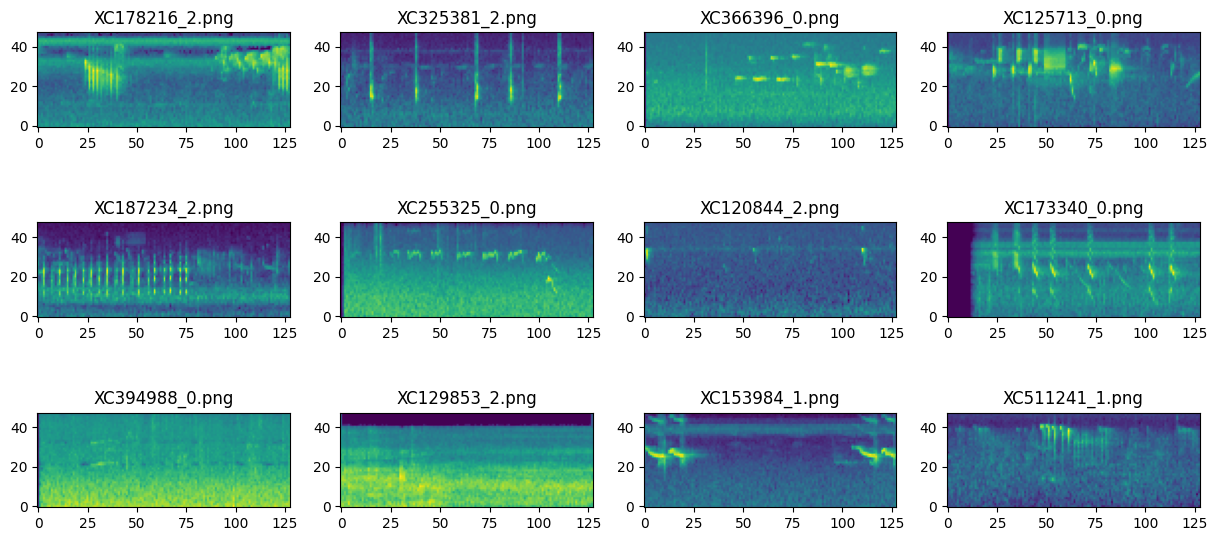

In [ ]:
plt.figure(figsize=(15, 7))
for i in range(12):
    spec = Image.open(TRAIN_SPECS[i])
    plt.subplot(3, 4, i + 1)
    plt.title(TRAIN_SPECS[i].split(os.sep)[-1])
    plt.imshow(spec, origin='lower')

***4. Load training samples***

In [ ]:
train_specs, train_labels = [], []
with tqdm(total=len(TRAIN_SPECS)) as pbar:
    for path in TRAIN_SPECS:
        pbar.update(1)

        spec = Image.open(path)

        spec = np.array(spec, dtype='float32')


        spec -= spec.min()
        spec /= spec.max()
        if not spec.max() == 1.0 or not spec.min() == 0.0:
            continue

        spec = np.expand_dims(spec, -1)

        spec = np.expand_dims(spec, 0)

        if len(train_specs) == 0:
            train_specs = spec
        else:
            train_specs = np.vstack((train_specs, spec))

        target = np.zeros((len(LABELS)), dtype='float32')
        bird = path.split(os.sep)[-2]
        target[LABELS.index(bird)] = 1.0
        if len(train_labels) == 0:
            train_labels = target
        else:
            train_labels = np.vstack((train_labels, target))

100%|██████████| 4587/4587 [01:47<00:00, 42.52it/s]


***Build a simple model***

In [ ]:
f1_score=F1Score(num_classes=len(LABELS),average='macro',name='f1_score')

***Model 2***

In [ ]:
tf.random.set_seed(RANDOM_SEED)


model2 = tf.keras.Sequential([

    # First conv block
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                           input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Second conv block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Third conv block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Fourth conv block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),



#     # Global pooling instead of flatten()
    tf.keras.layers.GlobalAveragePooling2D(),

    # Dense block
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.5),

    # Classification layer
    tf.keras.layers.Dense(len(LABELS), activation='softmax')
])



print('MODEL HAS {} PARAMETERS.'.format(model2.count_params()))

MODEL HAS 117849 PARAMETERS.


In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy',f1_score])

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1_score',
                                                  mode='max',
                                                  patience=2,
                                                  verbose=1,
                                                  factor=0.5),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=20),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model2.h5',
                                                mode='max',
                                                monitor='val_f1_score',
                                                verbose=0,
                                                save_best_only=True)]

In [ ]:
def plot_history(history):
    his=pd.DataFrame(history.history)
    plt.subplots(1,2,figsize=(16,8))

    #loss:
    plt.subplot(1,2,1)
    plt.plot(range(len(his)),his['loss'],color='g',label='training')
    plt.plot(range(len(his)),his['val_loss'],color='r',label='validation')
    plt.legend()
    plt.title('Loss')

    #accuracy
    plt.subplot(1,2,2)
    plt.plot(range(len(his)),his['accuracy'],color='g',label='training_acc')
    plt.plot(range(len(his)),his['val_accuracy'],color='r',label='validation_acc')

#     #f1_score
#     plt.plot(range(len(his)),his['f1_score'],color='steelblue',label='training_f1')
#     plt.plot(range(len(his)),his['val_f1_score'],color='maroon',label='validation_f1')

    plt.legend()
    plt.title('accuracy')

    plt.show()

Epoch 1/50
115/115 [==============================] - 12s 17ms/step - loss: 3.1860 - accuracy: 0.1033 - f1_score: 0.0974 - val_loss: 3.5022 - val_accuracy: 0.0305 - val_f1_score: 0.0054 - lr: 0.0010
Epoch 2/50
115/115 [==============================] - 1s 8ms/step - loss: 2.7131 - accuracy: 0.2246 - f1_score: 0.2141 - val_loss: 3.8816 - val_accuracy: 0.0294 - val_f1_score: 0.0023 - lr: 0.0010
Epoch 3/50
115/115 [==============================] - 1s 9ms/step - loss: 2.4230 - accuracy: 0.3009 - f1_score: 0.2914 - val_loss: 3.4142 - val_accuracy: 0.0392 - val_f1_score: 0.0153 - lr: 0.0010
Epoch 4/50
115/115 [==============================] - 1s 10ms/step - loss: 2.2036 - accuracy: 0.3633 - f1_score: 0.3562 - val_loss: 2.7440 - val_accuracy: 0.2092 - val_f1_score: 0.2056 - lr: 0.0010
Epoch 5/50
115/115 [==============================] - 1s 11ms/step - loss: 2.0245 - accuracy: 0.4265 - f1_score: 0.4197 - val_loss: 2.1423 - val_accuracy: 0.4052 - val_f1_score: 0.4062 - lr: 0.0010
Epoch 6/50


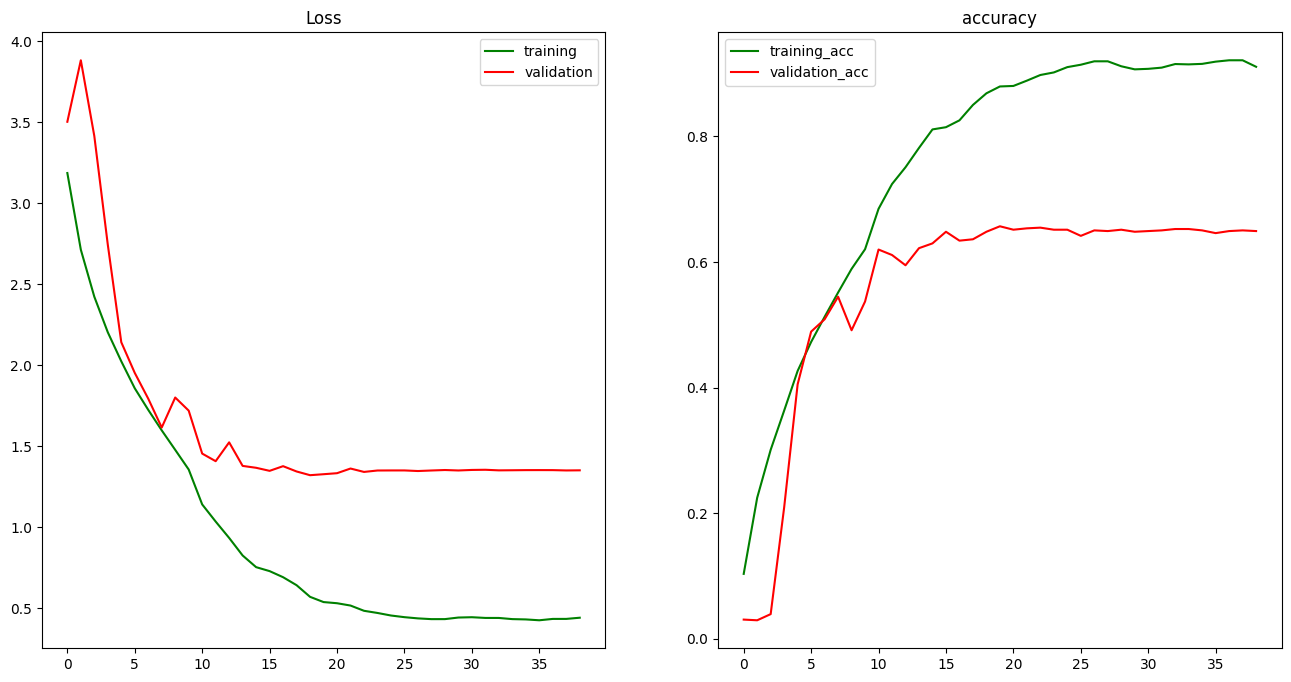

In [ ]:
his2=model2.fit(train_specs,
          train_labels,
          batch_size=32,
          validation_split=0.2,
          callbacks=callbacks,
          verbose=1,
          epochs=EPOCHS)

plot_history(his2)

In [ ]:
model_path = '/content/gdrive/MyDrive/DsiM/modello.h5'
model2.save(model_path)
